Code needs a cleenup and potentially introduction fo symmetries to diagonalize larger lattices. A possible run dow of what could be interesting to do:
1. Clean up the code and commenting more;
2. Invest some time on the ladder: can we reproduce Debaseesh ladder results? Isn't this mapped to PXP by dual transformations?
3. Reproduce Debaseesh's results on less ladery shapes and compare what happens. Can we observe exactly the same thing? Is there new things comming up? Maybe related to string fractionalization and such?
4. Can we introduce matter (either here or in the square) and identify these lowentropy states?

In [4]:
%matplotlib notebook
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
%config InlineBackend.figure_format = 'svg'

from matplotlib.pyplot import*
from numpy import zeros, array,log,dot,sqrt,conjugate,real,imag,arange
from scipy.sparse.linalg import eigs
from scipy.linalg import eigh,eig
from scipy.optimize import minimize
from copy import deepcopy
from time import time

In [5]:
def st2n(st):
    return int(sum([a*2**(len(st)-i-1) for i,a in enumerate((st+1)//2)]))

def verify_gauss(Lx,Ly,st):
    for x in range(Lx):
        for y in range(Ly):
            r=y*Lx+x
            g=0
            g=2*int(st[3*r])-1
            g-=2*int(st[3*r+1])-1
            g+=2*int(st[3*r+2])-1
            rn=y*Lx+(x-1)%Lx
            g-=2*int(st[3*rn])-1
            rn=((y-1)%Ly)*Lx+x
            g+=2*int(st[3*rn+1])-1
            rn=((y-1)%Ly)*Lx+(x+1)%Lx
            g-=2*int(st[3*rn+2])-1
            if g!=0:
                return False
    return True

def restricted_operator(oper,basis):
    N=len(basis)
    r_oper=zeros((N,N))
    for i in range(N):
        for j in range(N):
            r_oper[i,j]=dot(basis[i],dot(oper,basis[j]))
    return r_oper

In [6]:
def Ham(Lx,Ly,lamb):
    nlinks=3*Lx*Ly
    N=2**nlinks
    count=0
    dic_n2full={}
    dic_full2n={}
    dic_n2st={}
    dic_st2n={}
    #t0=time()
    for i in range(0,N,7):
        #if i%10**6==0:
        #    print(i,time()-t0)
        #    t0=time()
        st=bin(i)[2:]
        st='0'*(nlinks-len(st))+st
        if verify_gauss(Lx,Ly,st):
            dic_n2full[count]=i
            dic_full2n[i]=count
            dic_n2st[count]=array([2*int(v)-1 for v in st],int)
            dic_st2n[''.join(map(str,(dic_n2st[count]+1)//2))]=count
            count+=1
    H=zeros((count,count),complex)
    Ok=zeros((count,count),complex)
    Op=zeros((count,count),complex)
    for n in range(count):
        st=dic_n2st[n]
        for x in range(Lx):
            for y in range(Ly):
                r=y*Lx+x
                if st[3*r]==st[3*r+1]:
                    rn=y*Lx+(x+1)%Lx
                    if st[3*r]==st[3*rn+2]:
                        H[n,n]+=lamb
                        Op[n,n]+=lamb
                        st_other=zeros(nlinks)+st
                        st_other[3*r]*=-1
                        st_other[3*r+1]*=-1
                        st_other[3*rn+2]*=-1
                        other_n=dic_full2n[st2n(st_other)]
                        H[n,other_n]=-1
                        Ok[n,other_n]=-1
    return H,Ok,Op,dic_n2st,dic_st2n

def translation_x(Lx,Ly,dic_n2st,dic_st2n):
    N=len(dic_n2st.keys())
    Tx=zeros((N,N),complex)
    for i in range(N):
        new_st=zeros(3*Lx*Ly,int)
        st=dic_n2st[i]
        for x in range(Lx):
            xn=(x-1)%Lx
            for y in range(Ly):
                for li in range(3):
                    new_st[3*(y*Lx+x)+li]=st[3*(y*Lx+xn)+li]
        j=dic_st2n[''.join(map(str,(new_st+1)//2))]
        Tx[j,i]=1
    return Tx

def translation_y(Lx,Ly,dic_n2st,dic_st2n):
    N=len(dic_n2st.keys())
    Ty=zeros((N,N),complex)
    for i in range(N):
        new_st=zeros(3*Lx*Ly,int)
        st=dic_n2st[i]
        for x in range(Lx):
            for y in range(Ly):
                yn=(y-1)%Ly
                for li in range(3):
                    new_st[3*(y*Lx+x)+li]=st[3*(yn*Lx+x)+li]
        j=dic_st2n[''.join(map(str,(new_st+1)//2))]
        Ty[j,i]=1
    return Ty

def wind_x(Lx,Ly,dic_n2st):
    N=len(dic_n2st.keys())
    Wx=zeros((N,N),complex)
    for i in range(N):
        s=0
        for y in range(Ly):
            p=1
            for x in range(Lx):
                li=2-x%2
                p*=int(dic_n2st[i][3*(y*Lx+x)+li])
            s+=p
        Wx[i,i]=s
    return Wx

def wind_y(Lx,Ly,dic_n2st):
    N=len(dic_n2st.keys())
    Wy=zeros((N,N),complex)
    for i in range(N):
        s=0
        for x in range(Lx):
            p=1
            for y in range(Ly):
                p*=int(dic_n2st[i][3*(y*Lx+x)])
                p*=int(dic_n2st[i][3*(y*Lx+(x+1)%Lx)+2])
            s+=p
        Wy[i,i]=s
    return Wy

In [7]:
def shannon(st):
    s=0
    for a in st:
        if abs(a)>0.000000001:
            s-=abs(a**2)*log(abs(a**2))
    return s

We can now follow a procedure that may not be the most efficient but should be enough to get the desired results. It consists on going through the list of operators that we want to simultaneously diagonalized and restrict our states to have the desired eigenvalues. For example:

1. Diagonalize T_x and select one eigenvalue collecting a set of states
2. Diagonalize T_y restricted to the set of states above, select an eigenvalue and collect those states
3. Again for W_x
4. Again for w_y
5. Finally, do it for H

To some extent we could do the first 4 points analitically, so this may be used to push our calculations further. Otherwise, we may brute force our way through.

In [8]:
def select_eigenvalue(w,v,wtarget):
    target_modes=[]
    dic_indices={}
    count=0
    for i,wi in enumerate(w):
        if abs(wi-wtarget)<.00000001:
            target_modes+=[v[:,i]]
            dic_indices[count]=i
            count+=1
    return dic_indices,target_modes

In [9]:
def restricted_operator(op,dic,states):
    n=len(dic)
    op_r=zeros((n,n),complex)
    for i in range(n):
        for j in range(n):
            op_r[i,j]=dot(conjugate(states[dic[i]]),dot(op,states[dic[j]]))
    return op_r

In [10]:
def state_reconstruction(st_r,target_indices,full_basis):
    st=zeros(len(full_basis[0]),complex)
    for i in range(len(st_r)):
        st+=st_r[i]*full_basis[:,target_indices[i]]
    return st

In [11]:
def is_eignestate(st,op):
    stn=dot(op,st)
    fact=dot(conjugate(stn),stn)
    if fact<.000000001:
        return True
    else:
        return abs(dot(conjugate(st),stn)/sqrt(fact)-1)<.000000001

In [12]:
#Construct H and dictionaries
Lx,Ly=4,2
lamb=1
H,Ok,Op,dic_n2st,dic_st2n=Ham(Lx,Ly,1)

In [72]:
#Define operators
Tx=translation_x(Lx,Ly,dic_n2st,dic_st2n)
Ty=translation_y(Lx,Ly,dic_n2st,dic_st2n)
Wx=wind_x(Lx,Ly,dic_n2st)
Wy=wind_y(Lx,Ly,dic_n2st)
operator_set=[Tx,Ty,Wx,Wy,H]
operator_names=['Tx','Ty','Wx','Wy','H']

In [82]:
#Define eigenvalues
eigen_set=[1.,1.,0,0.]

In [84]:
w,v=eig(operator_set[0])
all_states=deepcopy(v)
dic={}
for i in range(len(w)):
    dic[i]=i
for a,op in enumerate(operator_set[1:]):
    print(operator_names[a])
    dic_indicies,modes=select_eigenvalue(w,v,eigen_set[a])
    for i in range(len(dic_indicies)):
        dic[i]=dic[dic_indicies[i]]
    for i in range(len(dic_indicies),len(dic)):
        del dic[i]
    op_r=restricted_operator(op,dic,all_states)
    if a==0:
        w,v=eig(op_r)
    else:
        w,v=eigh(op_r)

Tx
Ty
Wx
Wy


error: (il>=1&&il<=n) failed for 6th keyword il: zheevr:il=1

In [85]:
w

array([4.])

In [87]:
wy,vy=eig(operator_set[3])

<IPython.core.display.Javascript object>


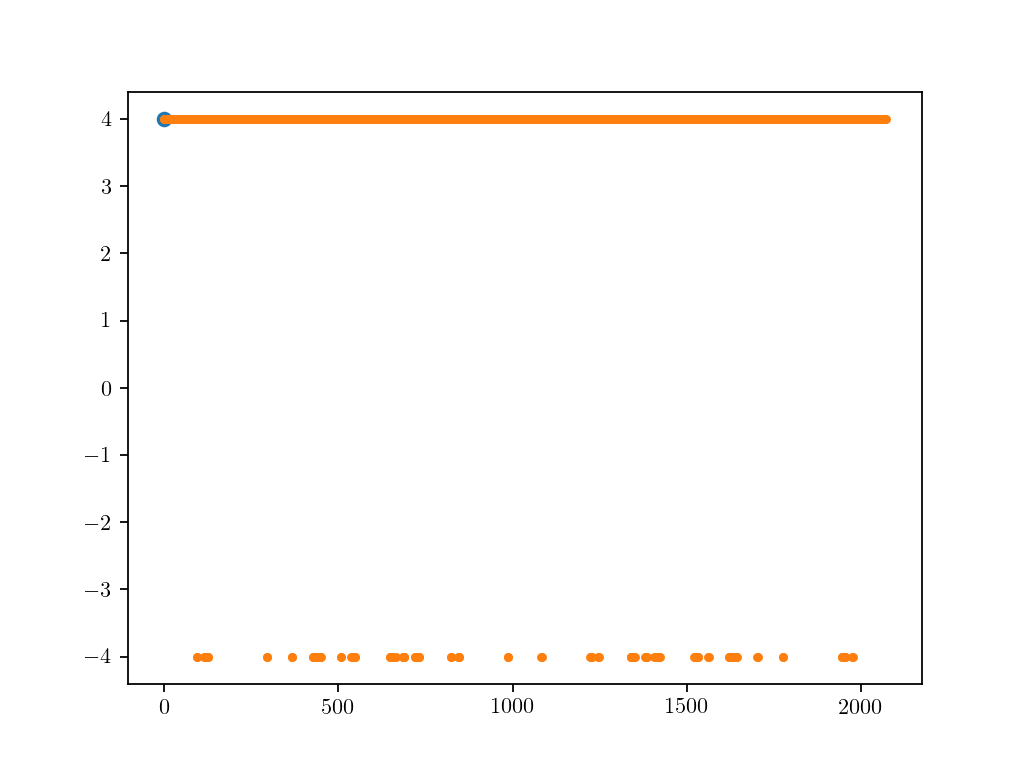

In [88]:
plot(range(len(w)),real(w),'o')
plot(range(len(wy)),real(wy),'.')

In [81]:
w

array([-1.00000000e+00+4.4408921e-16j,  5.55111512e-17+1.0000000e+00j,
       -2.76424467e-17-1.0000000e+00j, ...,
        1.00000000e+00+0.0000000e+00j,  1.00000000e+00+0.0000000e+00j,
        1.00000000e+00+0.0000000e+00j])

In [6]:
wOp,vOp=eigh(Op)
wOk,vOk=eigh(Ok)
wH,vH=eigh(H)

<IPython.core.display.Javascript object>


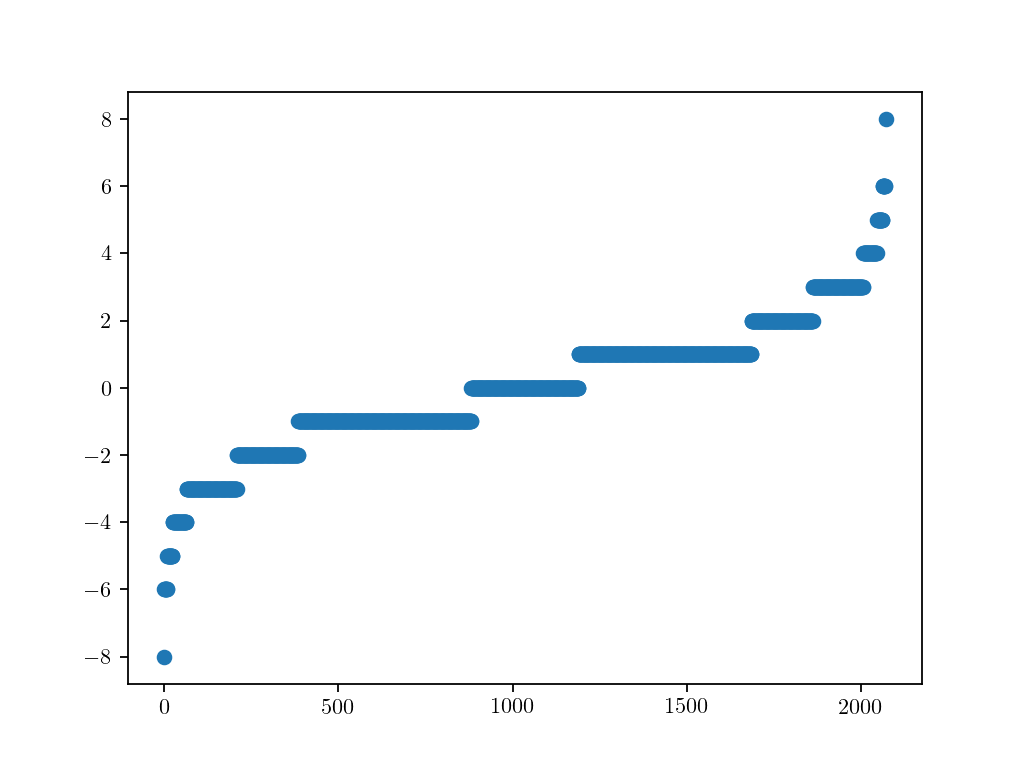

In [7]:
plot(range(len(wOk)),wOk,'o')

In [19]:
zero_indicies,zero_modes=select_eigenvalue(wOk,vOk,.0)

In [20]:
Op_r=restricted_operator(Op,zero_modes)

In [21]:
wOp_r,vOp_r=eigh(Op_r)

In [27]:
possible_scars=[]
for i in range(len(wOp_r)):
    possible_scars+=[state_reconstruction(vOp_r[:,i],zero_indicies,vOk)]

In [30]:
true_eignestates=[]
for st in possible_scars:
    if is_eignestate(st,H):
        true_eignestates+=[st]

In [31]:
print(len(possible_scars),len(true_eignestates))

308 308


<IPython.core.display.Javascript object>


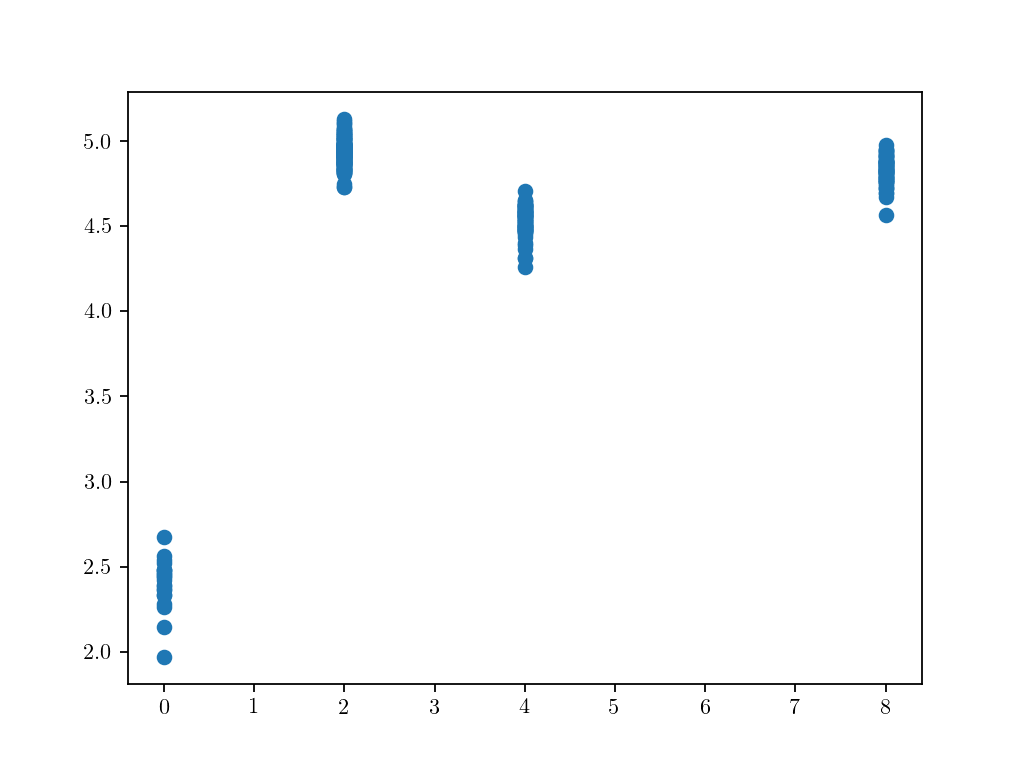

In [32]:
plot(wOp_r,[shannon(st) for st in true_eignestates],'o')

<IPython.core.display.Javascript object>


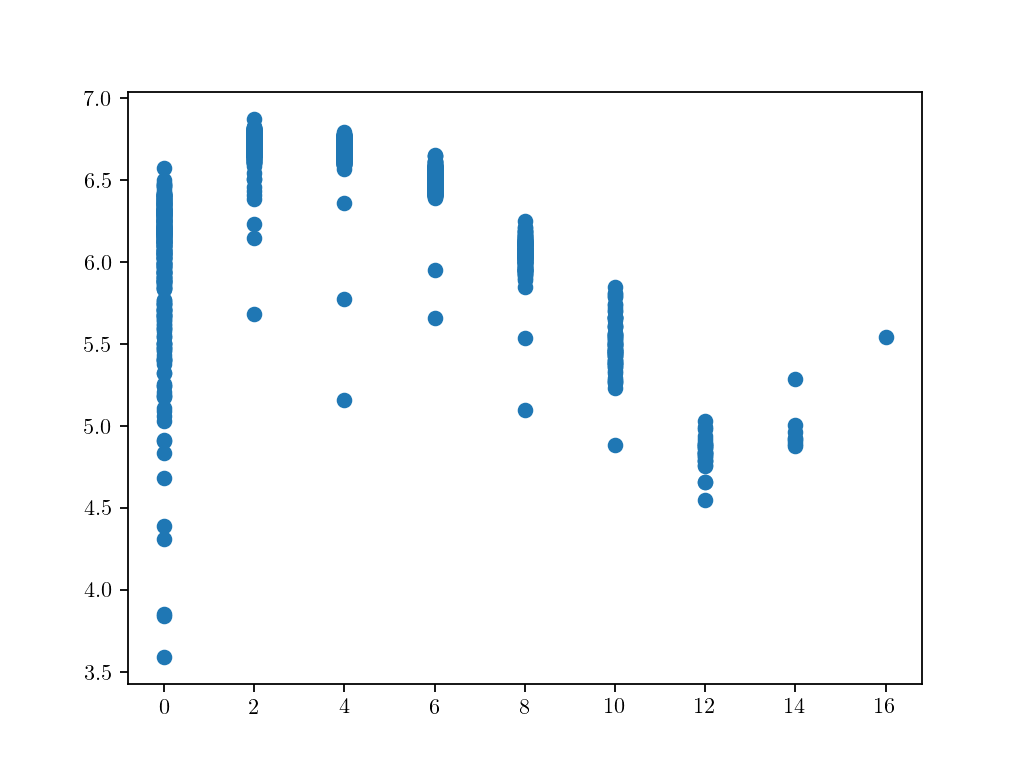

In [33]:
plot(wH,[shannon(vH[:,i]) for i in range(len(vH))],'o')

In [13]:
w,v=eigh(H)

In [15]:
w2,v2=eigh(Ok+2*Op)

In [ ]:
w3,v3=eigh(Ok+3*Op)

In [ ]:
w4,v4=eigh(Ok+4*Op)

In [21]:
w5,v5=eigh(Ok+5*Op)

<IPython.core.display.Javascript object>


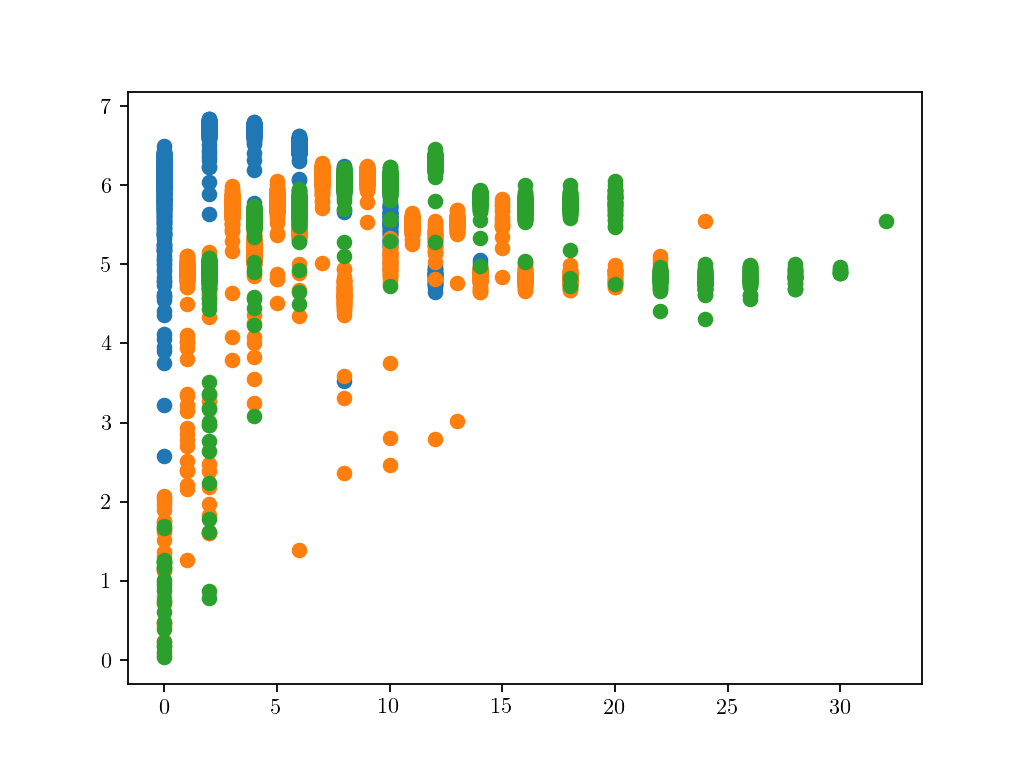

In [15]:
plot(w,[shannon(v[:,i]) for i in range(len(w))],'o')
plot(w2,[shannon(v2[:,i]) for i in range(len(w))],'o')
plot(w3,[shannon(v3[:,i]) for i in range(len(w))],'o')

<IPython.core.display.Javascript object>


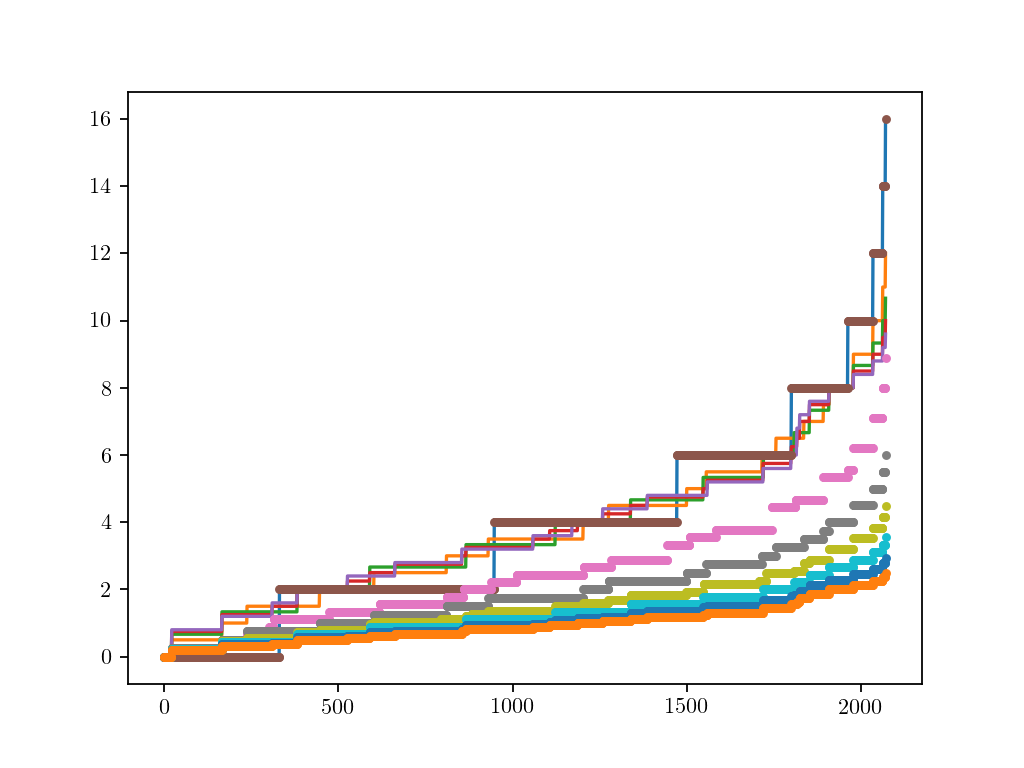

In [22]:
plot(range(len(w)),w,'-')
plot(range(len(w)),w2/2,'-')
plot(range(len(w)),w3/3,'-')
plot(range(len(w)),w4/4,'-')
plot(range(len(w)),w5/5,'-')

In [16]:
wlst=[]
for la in arange(1.,10.,.5):
    w,v=eigh(Ok+la*Op)
    wlst+=[w/la]

<IPython.core.display.Javascript object>


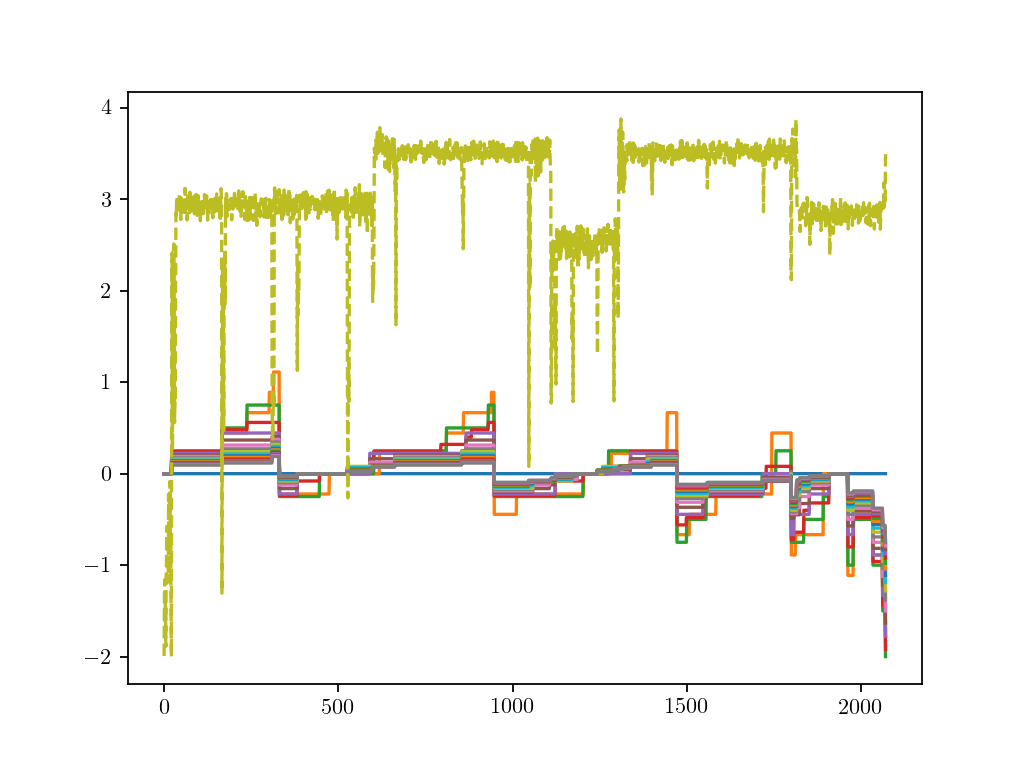

In [17]:
for i,la in enumerate(arange(1.,10.,.5)):
    plot(range(len(wlst[0])),(wlst[i]-wlst[0])/la,'-')
plot(range(len(wlst[0])),[shannon(v[:,i])-2 for i in range(len(w))],'--')


In [18]:
for j in range(len(wlst[0])):
    s=sum([abs((wlst[i][j]-wlst[0][j])/la) for i in range(1,18)])
    if s<.0000000001:
        print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960


In [19]:
v[:,i]


array([-3.47478157e-48+0.j, -7.30420654e-18+0.j,  8.91330541e-18+0.j, ...,
       -2.81673819e-18+0.j, -6.75355202e-18+0.j,  1.54074396e-32+0.j])

In [20]:
for i,q in enumerate(v[:,0]):
    if abs(q)>10**(-6):
        print(i,q)

162 (5.943778677664498e-05-0j)
185 (5.28737654400169e-05-0j)
321 (0.01425629187265638-0j)
335 (0.004885103300804728-0j)
714 (1.2926194864537829e-05-0j)
845 (-0.00030608556654563245-0j)
868 (0.00024077476503955427-0j)
892 (-4.829123403515937e-06-0j)
916 (0.9995781962200235-0j)
1001 (-0.00012341175439229806-0j)
1014 (-3.316600093407123e-06-0j)
1055 (-1.8872722793363178e-05-0j)
1068 (0.00010304773502317403-0j)
1177 (-6.394014928860975e-05-0j)
1201 (-2.5238118062000435e-06-0j)
1224 (-4.2139819978354345e-05-0j)
1355 (-0.00011529202459728527-0j)
1734 (-0.0002283982791091926-0j)
1748 (-0.024820669931482423-0j)
1907 (4.6563867586752834e-05-0j)


In [28]:
for i,q in enumerate(v[:,1]):
    if abs(q)>10**(-6):
        print(i,q)

162 (0.00025306696171176115-0j)
185 (-0.0007880146817354145-0j)
321 (0.46204443432844794-0j)
335 (0.17260178126520642-0j)
714 (0.00012404017224983526-0j)
845 (0.0017930650846784883-0j)
868 (0.00017428088838355362-0j)
892 (-1.0012143898410459e-05-0j)
916 (0.014163275264501757-0j)
1001 (-8.89035564658172e-05-0j)
1014 (-0.00117972640647707-0j)
1055 (-0.0017476232904979213-0j)
1068 (0.0006672506172206155-0j)
1153 (-0.00010401315332855236-0j)
1177 (0.00013036465715225668-0j)
1201 (-0.0003090704496968472-0j)
1224 (0.0001313226326541482-0j)
1355 (-0.0002747334027369431-0j)
1734 (-0.004608906128480865-0j)
1748 (0.869765857316044-0j)
1884 (-0.00010536611765989094-0j)
1907 (-8.179232359881013e-05-0j)


In [22]:
w[0]

-4.5941646250538056e-14

In [23]:
w[1]

-3.284060207872984e-14

In [24]:
w[2]

-3.284060207872984e-14

In [25]:
w[3]

-1.9739557906921624e-14

<IPython.core.display.Javascript object>


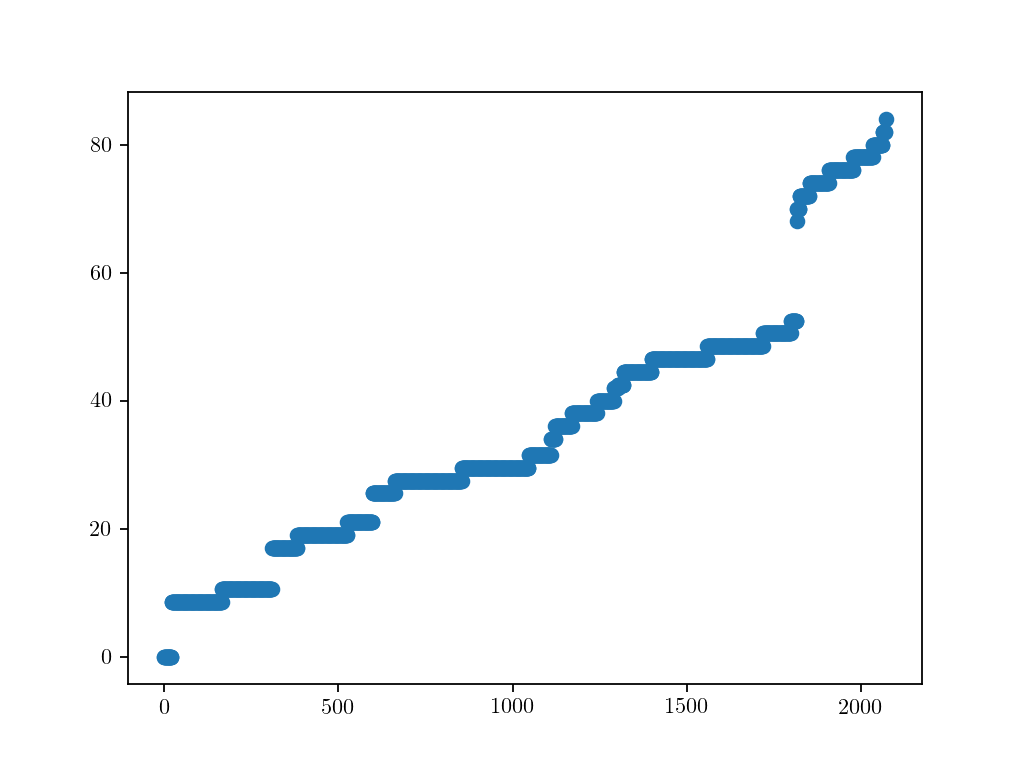

In [26]:
plot(range(len(w)),w,'o')

In [29]:
dot(v[:,0],v[:,1])

(3.9898639947466563e-17+0j)